### Notice
#### The original code for GP-VAE can be found in the author's repository. https://github.com/abudesai/timeVAE

### Library import

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from Libs.TIMEVAE.vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from Libs.TIMEVAE.vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from Libs.TIMEVAE.vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
import Libs.TIMEVAE.utils
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import ArgumentParser

from Libs.EvaluationModules import RCPEI_BTI, HeatMap_BTI, VCSAE_BTI, VisReconGivenZ_BTI


## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))     



### Parameter setting

In [2]:
SigType ='rawART'
### Model related parameters
LatDim = 30

file_pref = 'TimeVae_Lat'+str(LatDim)+'_' 
Outdir = './Results/'

In [3]:
TrData = np.load('../Data/ProcessedData/Tr'+str(SigType)+'.npy').astype('float32')
ValData = np.load('../Data/ProcessedData/Val'+str(SigType)+'.npy').astype('float32')


TrDataFrame = tf.signal.frame(TrData, 50, 50).numpy()
ValDataFrame = tf.signal.frame(ValData, 50, 50).numpy()


### Model load and predict

In [4]:
# Load
vae = TimeVAE.load(Outdir, file_pref)
Recon = vae.predict(ValDataFrame, batch_size=1000, verbose=1).reshape(-1, 1000)



60/60 [==============================] - 6s 16ms/step


### Reconstruction MSE check

In [5]:
np.mean((Recon- ValData)**2)

0.001513818

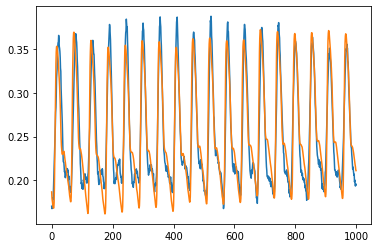

In [6]:
idx = 5400
plt.plot(Recon[idx])
plt.plot(ValData[idx])

### Draw random prior samples

In [7]:
N_Exp= 200

# print("num_samples: ", num_samples)
samples = vae.get_prior_samples(num_samples=N_Exp).reshape(-1, 1000)

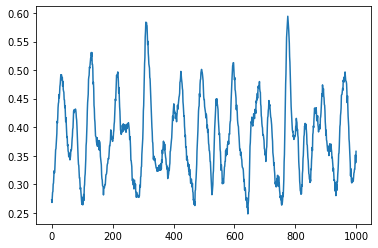

In [8]:
plt.plot(samples[5])

### RCPEI evaluation

In [11]:
VCSAE_Res = VCSAE_BTI(vae,  LatDim, N_Gen=300,   MinZval = -5., MaxZval = 5., N_FreqSel =3 )

['Lat_ID', 'Numerator', 'Denominator', 'VCSAE']
[0, 0.38739, 1.08005, 0.35868]
[1, 0.45763, 1.11035, 0.41215]
[2, 0.41073, 0.98627, 0.41645]
[3, 0.40008, 1.08021, 0.37037]
[4, 0.69735, 1.17438, 0.5938]
[5, 0.51551, 1.08817, 0.47374]
[6, 0.4679, 1.24656, 0.37536]
[7, 0.47926, 1.09367, 0.43821]
[8, 0.59427, 1.53817, 0.38635]
[9, 0.37484, 1.15102, 0.32565]
[10, 0.77782, 1.52141, 0.51125]
[11, 0.57134, 0.92336, 0.61876]
[12, 0.67506, 1.56014, 0.43269]
[13, 0.37656, 0.89576, 0.42038]
[14, 0.54428, 0.98237, 0.55405]
[15, 0.39683, 1.11984, 0.35437]
[16, 0.54196, 0.87601, 0.61866]
[17, 0.36381, 1.08277, 0.336]
[18, 0.65778, 1.55148, 0.42397]
[19, 0.47751, 0.98059, 0.48696]
[20, 0.8413, 1.58132, 0.53202]
[21, 0.68689, 0.90776, 0.75668]
[22, 0.83824, 1.58564, 0.52864]
[23, 0.39654, 1.55205, 0.2555]
[24, 0.40575, 1.06475, 0.38108]
[25, 0.3766, 1.13784, 0.33098]
[26, 0.41942, 1.13711, 0.36884]
[27, 0.62993, 1.56502, 0.40251]
[28, 0.57485, 0.94544, 0.60802]
[29, 0.37952, 1.24509, 0.30481]


### Heatmap visualization

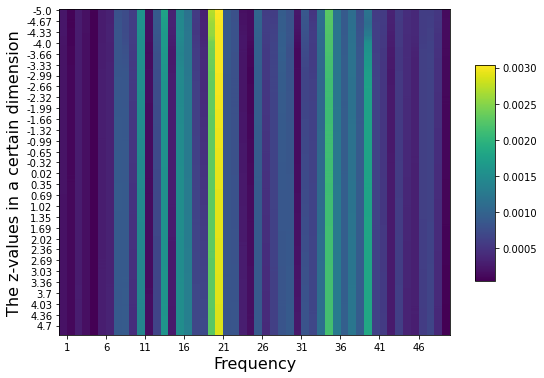

In [9]:
MinZval = -5.
MaxZval = 5.
N_Gen = 300

zValues = np.linspace(MinZval , MaxZval , N_Gen)
ZFix = {2 : zValues}
HeatMap_BTI(vae, LatDim=30, ZFix = ZFix)

### Reconstruction visualization

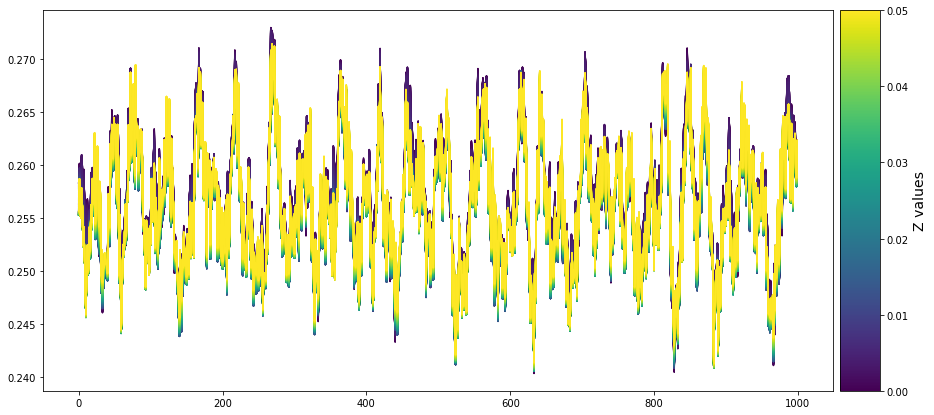

In [10]:
RecPred = VisReconGivenZ_BTI(vae, LatDim, ZFix, N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

In [13]:
Model = vae
LatDim = 30
N_Gen=300
MinZval = -5.
MaxZval = 5.
N_FreqSel =3
MinFreq=1
MaxFreq=51 
import EntropyHub as EH


In [12]:
import EntropyHub as EH

## The ratio of the variance concentration of the axis with strong amplitude to entropy (VCSAE)
def VCSAE_BTI (Model,  LatDim, N_Gen=300,   MinZval = -5., MaxZval = 5., N_FreqSel =3, MinFreq=1, MaxFreq=51 ):
    zValues = np.linspace(MinZval , MaxZval , N_Gen)
    ResList = []
    print(['Lat_ID', 'Numerator', 'Denominator', 'VCSAE'])
    for LatIdx in range(LatDim):
      
        zZeros = np.tile(np.zeros(LatDim), (N_Gen, 1))
        zZeros[:, LatIdx] = zValues

        ''' When given z latent values that have non-zero values in only one dimension, 
        generate signals of N_Gen size, then return the amplitude of the frequency through a Fourier transform. 2D Max[N_Gen, Zs.]'''
        SigGen = Model.decoder.predict(zZeros).reshape(N_Gen, -1)
        HalfLen = SigGen.shape[1]//2
        FFTRes = np.abs(np.fft.fft(SigGen, axis=-1)[:, :HalfLen]) 
        Amplitude = FFTRes/HalfLen
        Heatmap = Amplitude[:, MinFreq:MaxFreq]
        np.random.seed(0)
        Heatmap += np.random.normal(0., 1e-7, (Heatmap.shape))

        ''' Calculate N(i.e., N_FreqSel) row-wise permutation entropy.'''
        MaxIDX = np.argsort(np.mean(Heatmap, axis=0))[-N_FreqSel:]
        ListRowWisePerEnt = []
        for IDSeq in MaxIDX:
            ListRowWisePerEnt.append(np.maximum(EH.PermEn(Heatmap[:, IDSeq])[0][-1], 0.))
        MeanRowWisePerEnt = np.mean(ListRowWisePerEnt)

        ''' Calculate column-wise permutation entropy.'''
        SortedIDX = np.argsort(Heatmap, axis=1)
        ListColWisePerEnt = []
        for IDSeq in SortedIDX.T:
            ListColWisePerEnt.append(np.maximum(EH.PermEn(IDSeq)[0][-1], 0.))
        MeanColWisePerEnt = np.mean(ListColWisePerEnt)    

        "The ratio of the variance concentration of the axis with strong amplitude to entropy"
        SumHeatmap = np.sum(Heatmap, axis=0)
        StdHeatmap = np.std(Heatmap, axis=0)

        Rank = np.argsort(-SumHeatmap).argsort()
        WeigRank = np.exp(-Rank)
        RateHeatmap = (SumHeatmap * WeigRank * StdHeatmap) / np.sum(SumHeatmap * WeigRank * StdHeatmap, axis=0)

        Numerator = np.sum(RateHeatmap**2)
        Denominator = MeanRowWisePerEnt + MeanColWisePerEnt
        VCSAE =  Numerator / Denominator 

        'Aggregate results.'
        Res = [LatIdx, np.round(Numerator, 5), np.round(Denominator, 5), np.round(VCSAE, 5)]
        print(Res)
        ResList.append(Res)

    return ResList

array([ 0.2113836 ,  0.16018811,  0.22737242,  0.24290523,  0.08101477,
        0.30113116,  0.19489478,  0.31483663,  0.25801867,  0.17785209,
        0.12261937,  0.10243483,  0.14181594,  0.10243483,  0.30113116,
        0.14181594,  0.42622866,  0.31483663,  0.5208413 ,  0.08101477,
       -0.        ,  0.28710689,  0.34135998,  0.14181594,  0.30113116,
        0.36679671,  0.27274371,  0.32824099,  0.35420767,  0.25801867,
        0.31483663,  0.41478028,  0.40312125,  0.14181594,  0.08101477,
        0.12261937,  0.32824099,  0.14181594,  0.41478028,  0.12261937,
        0.40312125,  0.25801867,  0.28710689,  0.30113116,  0.14181594,
        0.22737242,  0.27274371,  0.42622866,  0.27274371,  0.16018811])

In [26]:
zValues = np.linspace(MinZval , MaxZval , N_Gen)
ResList = []
print(['Lat_ID', 'Numerator', 'Denominator', 'VCSAE'])
for LatIdx in range(LatDim):

    zZeros = np.tile(np.zeros(LatDim), (N_Gen, 1))
    zZeros[:, LatIdx] = zValues

    ''' When given z latent values that have non-zero values in only one dimension, 
    generate signals of N_Gen size, then return the amplitude of the frequency through a Fourier transform. 2D Max[N_Gen, Zs.]'''
    SigGen = Model.decoder.predict(zZeros).reshape(N_Gen, -1)
    HalfLen = SigGen.shape[1]//2
    FFTRes = np.abs(np.fft.fft(SigGen, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    Heatmap = Amplitude[:, MinFreq:MaxFreq]
    np.random.seed(0)
    Heatmap += np.random.normal(0., 1e-7, (Heatmap.shape))

    ''' Calculate N(i.e., N_FreqSel) row-wise permutation entropy.'''
    MaxIDX = np.argsort(np.mean(Heatmap, axis=0))[-N_FreqSel:]
    ListRowWisePerEnt = []
    for IDSeq in MaxIDX:
        ListRowWisePerEnt.append(np.maximum(EH.PermEn(Heatmap[:, IDSeq])[0][-1], 0.))
    MeanRowWisePerEnt = np.mean(ListRowWisePerEnt)

    ''' Calculate column-wise permutation entropy.'''
    SortedIDX = np.argsort(Heatmap, axis=1).argsort()
    ListColWisePerEnt = []
    for IDSeq in SortedIDX.T:
        ListColWisePerEnt.append(np.maximum(EH.PermEn(IDSeq)[0][-1], 0.))
    ColWisePerEnt = np.array(ListColWisePerEnt)

    "The ratio of the variance concentration of the axis with strong amplitude to entropy"
    SumHeatmap = np.sum(Heatmap, axis=0)
    StdHeatmap = np.std(Heatmap, axis=0)

    WeigRank = np.exp(-ColWisePerEnt)
    RateHeatmap = (SumHeatmap * WeigRank * StdHeatmap) / np.sum(SumHeatmap * WeigRank * StdHeatmap, axis=0)

    Numerator = np.sum(RateHeatmap**2)
    Denominator = MeanRowWisePerEnt
    VCSAE =  Numerator / Denominator 

    'Aggregate results.'
    Res = [LatIdx, np.round(Numerator, 5), np.round(Denominator, 5), np.round(VCSAE, 5)]
    print(Res)
    ResList.append(Res)

['Lat_ID', 'Numerator', 'Denominator', 'VCSAE']
[0, 0.06411, 0.9799, 0.06543]
[1, 0.06054, 0.98668, 0.06136]
[2, 0.07447, 0.89034, 0.08364]
[3, 0.06019, 0.93469, 0.06439]
[4, 0.12494, 0.78751, 0.15866]
[5, 0.07217, 0.81122, 0.08896]
[6, 0.08605, 0.97458, 0.08829]
[7, 0.04903, 0.88151, 0.05562]
[8, 0.15824, 0.99818, 0.15853]
[9, 0.06358, 0.98975, 0.06424]
[10, 0.36114, 0.99384, 0.36338]
[11, 0.10705, 0.8099, 0.13217]
[12, 0.2613, 0.99801, 0.26182]
[13, 0.05261, 0.78116, 0.06734]
[14, 0.05973, 0.84636, 0.07057]
[15, 0.05017, 0.8791, 0.05707]
[16, 0.05536, 0.72097, 0.07679]
[17, 0.04404, 0.9507, 0.04632]
[18, 0.2416, 0.99846, 0.24198]
[19, 0.07424, 0.8318, 0.08925]
[20, 0.46233, 0.99984, 0.4624]
[21, 0.06676, 0.84955, 0.07859]
[22, 0.35407, 0.993, 0.35656]
[23, 0.03682, 0.9426, 0.03906]
[24, 0.05424, 0.94174, 0.0576]
[25, 0.04506, 0.98645, 0.04567]
[26, 0.0574, 0.85869, 0.06684]
[27, 0.15325, 0.97042, 0.15793]
[28, 0.05325, 0.83551, 0.06373]
[29, 0.06988, 0.99695, 0.07009]
